# Implementation of Rotation-Invariant CNN Using PyTorch

This notebook focuses on the implementation of a Convolutional Neural Network (CNN) designed to be invariant to the orientation of features in the input data. The theoretical background and mathematical formulation are detailed in [this notebook](https://colab.research.google.com/drive/1FtJcQycf_XP6kAB_jJTuQAknxQiRnEj-?usp=drive_link). Here, we will develop, train, and evaluate the CNN using PyTorch.


In [1]:
# Import necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Set up the GPU settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using {device} device')

Using cuda device


In [2]:
# Define a transformation for MNIST that includes random rotations
mnist_transform = transforms.Compose([
    transforms.RandomRotation(degrees=(0, 360)),  # Randomly rotates images between 0 and 360 degrees
    transforms.ToTensor(),  # Converts to Tensor and scales pixels between 0 and 1
    transforms.Normalize((0.1307,), (0.3081,))  # Normalizes the dataset
])

# Downloading and loading MNIST dataset with rotation
train_dataset = datasets.MNIST(root='./data', train=True, transform=mnist_transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=mnist_transform)

# Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


In [3]:
def vector_aggregation(x):
    # Ensure input is in expected vector field format [batch, channels, height, width, 2]
    assert x.dim() == 6 and x.shape[-1] == 2, "Input must be 6D with last dim 2 (magnitude, phase)."

    #print("Size before aggregation:", x.shape)

    magnitude = x[..., 0]
    phase = x[..., 1]

    # Convert vector field to Cartesian coordinates
    x_cartesian = magnitude * torch.cos(phase)
    y_cartesian = magnitude * torch.sin(phase)

    # Sum Cartesian components across all channels
    summed_x = torch.sum(x_cartesian, dim=2, keepdim=False)
    summed_y = torch.sum(y_cartesian, dim=2, keepdim=False)

    # Convert back to polar coordinates
    output_magnitude = torch.sqrt(summed_x**2 + summed_y**2)
    output_phase = torch.atan2(summed_y, summed_x)

    #print("Size after aggregation:", torch.stack([output_magnitude, output_phase], dim=-1).squeeze(2).shape)

    return torch.stack([output_magnitude, output_phase], dim=-1)

class VectorConv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
    super(VectorConv2d, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = (kernel_size, kernel_size)
    self.stride = stride
    self.padding = padding

    # Define the weights for the magnitudes and phases of the filters
    self.filter_x = nn.Parameter(torch.randn(out_channels, in_channels, *self.kernel_size))
    self.filter_y = nn.Parameter(torch.randn(out_channels, in_channels, *self.kernel_size))

    if bias:
      self.bias = nn.Parameter(torch.randn(out_channels))
    else:
      self.bias = None

  def forward(self, x):
    assert x.dim() == 5 and x.shape[-1] == 2, "Input to VectorConv2d should be 5D with last dim 2."

    magnitude = x[..., 0]
    phase = x[..., 1]

    # Convert from polar to cartesian
    x_cart = magnitude * torch.cos(phase)
    y_cart = magnitude * torch.sin(phase)

    # Rotate the filters
    rotated_filter_x = self.rotate_filters(self.filter_x)
    rotated_filter_y = self.rotate_filters(self.filter_y)
    bias = self.bias.repeat(4)

    # Apply convolution in cartesian coordinates
    real_conv = F.conv2d(x_cart, rotated_filter_x, bias, self.stride, self.padding) - \
                F.conv2d(y_cart, rotated_filter_y, None, self.stride, self.padding)
    imag_conv = F.conv2d(x_cart, rotated_filter_y, None, self.stride, self.padding) + \
                F.conv2d(y_cart, rotated_filter_x, None, self.stride, self.padding)

    # Reshape to isolate rotations to their own axis
    batch_size, _, height, width = real_conv.shape
    x_conv = real_conv.view(batch_size, self.out_channels, 4, height, width)
    y_conv = imag_conv.view(batch_size, self.out_channels, 4, height, width)
      
    # Convert the results to polar coordinates
    output_mag = torch.sqrt(x_conv**2 + y_conv**2)
    output_phase = torch.atan2(y_conv, x_conv)

    # Apply Max Pooling, drop excess rotation channels
    max_magnitude, max_indices = torch.max(output_mag, dim=2, keepdim=True)
    max_phase = torch.gather(output_phase, 2, max_indices)

    vectorized_output = torch.stack([max_magnitude.squeeze(2), max_phase.squeeze(2)], dim=-1)
    return vectorized_output

  def rotate_filters(self, filters):
    rotated_filters = torch.stack([
      filters,
      filters.transpose(2, 3).flip(2),
      filters.flip(2).flip(3),
      filters.transpose(2, 3).flip(3)
    ], dim=0).view(-1, *filters.shape[1:])
    return rotated_filters

class VectorTransformConv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
    super(VectorTransformConv2d, self).__init__()

    # Parameters for the convolution operation
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = (kernel_size, kernel_size)
    self.stride = stride
    self.padding = padding
    self.dilation = dilation
    self.groups = groups

    # Learnable parameters: weights and bias
    self.filters = nn.Parameter(torch.randn(out_channels, in_channels, *self.kernel_size))
    self.bias = nn.Parameter(torch.randn(out_channels)) if bias else None

    # Phase iteration: angular spacing between rotations
    self.phase_values = nn.Parameter(torch.tensor([0, torch.pi/2, torch.pi, 3*torch.pi/2]), requires_grad=False)

  def forward(self, x):
    # Apply convolution with each rotated filter and stack the outputs
    output = F.conv2d(x, self.rotate_filters(self.filters), self.bias.repeat(4), self.stride, self.padding, self.dilation, self.groups)
      
    # Reshape output to separate filters from rotations
    batch_size, _, height, width = output.shape
    output = output.view(batch_size, self.out_channels, 4, height, width)
    phase = self.phase_values.repeat(self.out_channels).view(1, self.out_channels, 4, 1, 1).expand(batch_size, -1, -1, height, width)

    max_magnitude, max_indices = torch.max(output, dim=2, keepdim=True)
    max_phase = torch.gather(phase, 2, max_indices)
    aggregated_output = torch.stack([max_magnitude, max_phase], dim=-1).squeeze(2)
    return aggregated_output

  def rotate_filters(self, filters):
    # Rotate the weight tensor by 0, 90, 180, and 270 degrees
    rotated_filters = torch.stack([
      filters,
      filters.transpose(2, 3).flip(2),
      filters.flip(2).flip(3),
      filters.transpose(2, 3).flip(3)
    ], dim=0).view(-1, *filters.shape[1:])
    return rotated_filters

class VectorMaxPool2d(nn.Module):
  def __init__(self, kernel_size, stride=None, padding=0):
    super(VectorMaxPool2d, self).__init__()
    # Initialize parameters similar to nn.MaxPool2d
    self.kernel_size = kernel_size
    self.stride = stride if stride is not None else kernel_size
    self.padding = padding

  def forward(self, x):
    # Extract magnitude and phase
    magnitude = x[..., 0]
    phase = x[..., 1]

    # Apply max pooling to the magnitude part
    pooled_magnitude, indices = F.max_pool2d(magnitude, self.kernel_size, self.stride, self.padding, return_indices=True)

    # Use the indices from max pooling on magnitude to gather corresponding phases
    # Phase tensor reshaping for gathering
    phase_flat = phase.view(phase.shape[0], phase.shape[1], -1) # Flatten height and width for indexing
    pooled_phase = torch.gather(phase_flat, 2, indices.view(phase.shape[0], phase.shape[1], -1))
    pooled_phase = pooled_phase.view_as(pooled_magnitude)

    pooled_output = torch.stack([pooled_magnitude, pooled_phase], dim=-1)
    return pooled_output


class Vector2Magnitude(nn.Module):
  def __init__(self):
    super(Vector2Magnitude, self).__init__()

  def forward(self, x):
    assert x.size(-1) == 2, "Input must be a vector feature map with last dim = 2"
    return x[..., 0]

def vector_relu(x):
  magnitude, phase = x[..., 0], x[..., 1]
  magnitude = F.relu(magnitude)
  return torch.stack([magnitude, phase], dim=-1)

In [10]:
class RI_CNN(nn.Module):
    def __init__(self):
        super(RI_CNN, self).__init__()
        # Define the first convolutional layer
        self.vector_transform = VectorTransformConv2d(1, 4, kernel_size=5, stride=1, padding=2)
        self.pool1 = VectorMaxPool2d(2, stride=2)
        
        # Define the second convolutional layer
        self.conv2 = VectorConv2d(4, 8, kernel_size=5, padding=2)
        self.pool2 = VectorMaxPool2d(2, stride=2)

        # Batch Normalization
        self.batch_norm = nn.BatchNorm2d(8)
        
        # Fully connected layers
        self.fc1 = nn.Linear(8*7*7, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        # Applying the first convolutional layer
        x = self.vector_transform(x)
        x = self.pool1(x)
        x = vector_relu(x)

        # Apply the second convolutional layer
        x = self.conv2(x)
        x = self.pool2(x)
        x = vector_relu(x)
        
        x = x[..., 0]
        x = self.batch_norm(x)
        
        # Flatten the output from the convolutional layers
        #print(x.shape)
        x = x.view(x.size(0), -1)  # Flatten for the fully connected layer
        
        # Apply the first fully connected layer with ReLU activation and dropout
        x = F.relu(self.fc1(x))
        
        # Apply the second fully connected layer to produce the final output
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

class BASE_CNN(nn.Module):
    def __init__(self):
        super(BASE_CNN, self).__init__()  # Changed superclass call to match class name
        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2, bias=True)
        self.pool1 = nn.MaxPool2d(2, stride=2)
        
        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(8, 8, kernel_size=5, stride=1, padding=2, bias=True)
        self.pool2 = nn.MaxPool2d(2, stride=2)

        # Batch Normalization
        self.batch_norm = nn.BatchNorm2d(8)
        
        # Fully connected layers
        self.fc1 = nn.Linear(8*7*7, 20)  # Adjusted the input size to match output from conv2
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        # Applying the first convolutional layer followed by ReLU and pooling
        x = self.conv1(x)
        x = self.pool1(x)
        x = F.relu(x)
        
        # Applying the second convolutional layer followed by ReLU and pooling
        x = self.conv2(x)
        x = self.pool2(x)
        x = F.relu(x)
        
        # Flatten the output from the convolutional layers for the fully connected layer
        x = x.view(x.size(0), -1)  # Flatten operation
        
        # Apply the first fully connected layer with ReLU activation and dropout
        x = F.relu(self.fc1(x))
        
        # Apply the second fully connected layer to produce the final output
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
our_model = RI_CNN().to(device)
basic_model = BASE_CNN().to(device)

def print_parameters_per_layer(model):
    for name, parameter in model.named_parameters():
        print(f"{name}: {parameter.numel()} parameters; Trainable: {parameter.requires_grad}")

# Using the example model
# print_parameters_per_layer(our_model)
# print_parameters_per_layer(basic_model)

trainable_params = sum(p.numel() for p in our_model.parameters() if p.requires_grad)
print("RI Total number of trainable parameters: ", trainable_params)

trainable_params = sum(p.numel() for p in basic_model.parameters() if p.requires_grad)
print("BASE Total number of trainable parameters: ", trainable_params)


RI Total number of trainable parameters:  9798
BASE Total number of trainable parameters:  9902


In [11]:
our_optimizer = optim.Adam(our_model.parameters(), lr=0.01)
basic_optimizer = optim.Adam(basic_model.parameters(), lr=0.01)
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        for name, param in model.named_parameters():
            if param.grad is not None:
                #print(f"{name}, Gradient: {param.grad.norm().item()}")
                pass

        optimizer.step()
        if batch_idx % 100 == 0:
            continue
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    #return test_loss


In [12]:
for epoch in range(1, 6):  # Run for 5 epochs
    train(our_model, device, train_loader, our_optimizer, epoch)
    test(our_model, device, test_loader)

Test set: Average loss: 0.5055, Accuracy: 8372/10000 (84%)

Test set: Average loss: 0.3633, Accuracy: 8836/10000 (88%)

Test set: Average loss: 0.3502, Accuracy: 8861/10000 (89%)

Test set: Average loss: 0.3198, Accuracy: 9001/10000 (90%)

Test set: Average loss: 0.3292, Accuracy: 8942/10000 (89%)



In [13]:
for epoch in range(1, 6):  # Run for 5 epochs
    train(basic_model, device, train_loader, basic_optimizer, epoch)
    test(basic_model, device, test_loader)

Test set: Average loss: 0.6150, Accuracy: 7987/10000 (80%)

Test set: Average loss: 0.5559, Accuracy: 8180/10000 (82%)

Test set: Average loss: 0.5515, Accuracy: 8243/10000 (82%)

Test set: Average loss: 0.5166, Accuracy: 8290/10000 (83%)

Test set: Average loss: 0.5018, Accuracy: 8390/10000 (84%)



Running training cycles:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/938 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/938 [00:00<?, ?it/s]

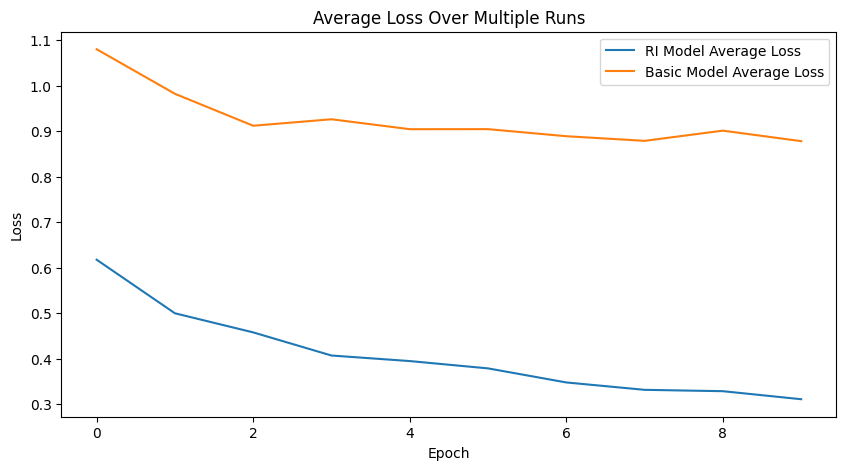

In [7]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

def train_test(model, optimizer, num_epochs=10):
    model.train()
    losses = []
    for epoch in range(num_epochs):
        epoch_losses = []
        for data, target in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        #losses.append(np.mean(epoch_losses))
        losses.append(test(model, device, test_loader))
    return losses

# Run training and collect losses
num_runs = 5
all_losses1 = []
all_losses2 = []

for _ in tqdm(range(num_runs), desc="Running training cycles"):
    our_model = RI_CNN().to(device)
    basic_model = BASE_CNN().to(device)
    our_optimizer = optim.Adam(our_model.parameters(), lr=0.01)
    basic_optimizer = optim.Adam(basic_model.parameters(), lr=0.01)
    all_losses1.append(train_test(our_model, our_optimizer))
    all_losses2.append(train_test(basic_model, basic_optimizer))

# Calculate average losses
avg_losses1 = np.mean(all_losses1, axis=0)
avg_losses2 = np.mean(all_losses2, axis=0)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(avg_losses1, label='RI Model Average Loss')
plt.plot(avg_losses2, label='Basic Model Average Loss')
plt.title('Average Loss Over Multiple Runs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Assuming `model` is your CNN model and it has at least one convolutional layer named 'conv1'
filters = our_model.vector_transform.filters.data.cpu().numpy()

import matplotlib.pyplot as plt

# Assuming filters are of shape (out_channels, in_channels, kernel_height, kernel_width)
# and the input images are grayscale (in_channels = 1)
n_filters = filters.shape[0]
plt.figure(figsize=(20, 17))

for i in range(n_filters):
    ax = plt.subplot((n_filters // 8) + 1, 8, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(filters[i, 0], cmap='gray')  # Index 0 for the first channel
    ax.set_title(f'Filter {i}')
plt.show()


In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import random

# Define a custom transformation that randomly rotates images by 0, 90, 180, or 270 degrees
class RandomRotationTransform:
    def __init__(self, angles):
        self.angles = angles

    def __call__(self, x):
        angle = random.choice(self.angles)
        return transforms.functional.rotate(x, angle)

# Apply the transformation to the MNIST test set
test_transform = transforms.Compose([
    RandomRotationTransform(angles=[0, 90, 180, 270]),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Download and load the test dataset with the custom transform
test_dataset = datasets.MNIST(root='./data', train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

def evaluate_model(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on the test set with random rotations: {accuracy:.2f}%')

# Assume the model and device are already set up
evaluate_model(model, device, test_loader)


Accuracy on the test set with random rotations: 46.46%


In [48]:
class RotatedFilterConv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, bias=True):
    super(RotatedFilterConv2d, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    self.stride = stride
    self.padding = padding
    self.dilation = dilation

    # Initialize weights for the base filters
    self.filters = nn.Parameter(torch.randn(out_channels, in_channels, kernel_size, kernel_size))
    self.rotated_filters = self.rotate_filters(self.filters)
    self.bias = nn.Parameter(torch.randn(out_channels)) if bias else None

  def forward(self, x):
    return F.conv2d(x, self.rotated_filters, self.bias, self.stride, self.padding, self.dilation)

  def rotate_filters(self, filters):
    rotated_filters = torch.stack([
      filters,
      filters.transpose(2, 3).flip(2),
      filters.flip(2).flip(3),
      filters.transpose(2, 3).flip(3)
    ], dim=0)
    return rotated_filters

In [ ]:
# Evaluation

In [ ]:
# Results and Conclusions